
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    # qs = tf.sigmoid(Qs) # qt
    # targetQs = qs + (gamma * nextQs)
    # # Calculating the loss: logits/predictions vs labels
    # q_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [10]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_D = qs + (gamma * nextQs_D)
    # Calculating the loss: logits/predictions vs labels
    #d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    d_loss = tf.reduce_mean(tf.square(Qs - nextQs_D))
    
    # Returning the D loss
    return d_loss

In [12]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [13]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize((q_loss + g_loss), var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize((d_loss + g_loss), var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss,
                                           g_loss=self.g_loss, 
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [17]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [18]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, g_loss, d_loss, _, _ = sess.run([model.q_loss,
                                                     model.g_loss,
                                                     model.d_loss,
                                                     model.g_opt,
                                                     model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3 Training q_loss: 0.0111 Training g_loss: 0.0016 Training d_loss: 0.0118 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 20 Training q_loss: 0.0157 Training g_loss: 0.0008 Training d_loss: 0.0032 Explore P: 0.9977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 19 Training q_loss: 0.1455 Training g_loss: 0.0009 Training d_loss: 0.0011 Explore P: 0.9959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 10 Training q_loss: 0.3257 Training g_loss: 0.0005 Training d_

-------------------------------------------------------------------------------
Episode: 30 Total reward: 30 Training q_loss: 31.8146 Training g_loss: 0.0015 Training d_loss: 0.0001 Explore P: 0.9345
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 30 Training q_loss: 14.2021 Training g_loss: 0.0005 Training d_loss: 0.0000 Explore P: 0.9317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 21 Training q_loss: 34.6267 Training g_loss: 0.9478 Training d_loss: 0.0001 Explore P: 0.9298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 14 Training q_loss: 81.9155 Training g_loss: 0.0925 Tr

-------------------------------------------------------------------------------
Episode: 60 Total reward: 30 Training q_loss: 37490.9922 Training g_loss: 22.0554 Training d_loss: 0.0001 Explore P: 0.8672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 33 Training q_loss: 61505.9492 Training g_loss: 1.6280 Training d_loss: 0.0002 Explore P: 0.8644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 35 Training q_loss: 83072.1328 Training g_loss: 180.5885 Training d_loss: 0.0026 Explore P: 0.8614
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 42 Training q_loss: 61864.9336 Training g_

-------------------------------------------------------------------------------
Episode: 89 Total reward: 26 Training q_loss: 60880944.0000 Training g_loss: 8.8856 Training d_loss: 0.0006 Explore P: 0.7857
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 90 Total reward: 52 Training q_loss: 112645672.0000 Training g_loss: 25248.2480 Training d_loss: 0.0007 Explore P: 0.7816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 49 Training q_loss: 67858400.0000 Training g_loss: 348.8295 Training d_loss: 0.0018 Explore P: 0.7779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 132 Training q_loss: 37640016

-------------------------------------------------------------------------------
Episode: 118 Total reward: 49 Training q_loss: 12504573952.0000 Training g_loss: 311.2763 Training d_loss: 0.0002 Explore P: 0.6777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 119 Total reward: 28 Training q_loss: 19143493632.0000 Training g_loss: 10386682.0000 Training d_loss: 0.0005 Explore P: 0.6759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 120 Total reward: 35 Training q_loss: 1743234688.0000 Training g_loss: 173916.2812 Training d_loss: 0.0001 Explore P: 0.6736
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 128 Traini

-------------------------------------------------------------------------------
Episode: 146 Total reward: 20 Training q_loss: 521731276800.0000 Training g_loss: 1106479.2500 Training d_loss: 0.0002 Explore P: 0.5503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 38 Training q_loss: 1037160546304.0000 Training g_loss: 108980.7031 Training d_loss: 0.0002 Explore P: 0.5482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 46 Training q_loss: 324933976064.0000 Training g_loss: 6184.5112 Training d_loss: 0.0001 Explore P: 0.5458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 42 Tr

-------------------------------------------------------------------------------
Episode: 174 Total reward: 199 Training q_loss: 18106902642688.0000 Training g_loss: 16785706.0000 Training d_loss: 0.0005 Explore P: 0.3743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 193 Training q_loss: 20382507597824.0000 Training g_loss: 32253096.0000 Training d_loss: 0.0014 Explore P: 0.3673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 199 Training q_loss: 22694668009472.0000 Training g_loss: 319144.8750 Training d_loss: 0.0004 Explore P: 0.3603
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total 

-------------------------------------------------------------------------------
Episode: 202 Total reward: 199 Training q_loss: 71921257414656.0000 Training g_loss: 4189062.7500 Training d_loss: 0.0004 Explore P: 0.2289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 199 Training q_loss: 178979524837376.0000 Training g_loss: 5586690.5000 Training d_loss: 0.0007 Explore P: 0.2246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 199 Training q_loss: 198411919818752.0000 Training g_loss: 858558.7500 Training d_loss: 0.0004 Explore P: 0.2204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total 

-------------------------------------------------------------------------------
Episode: 230 Total reward: 199 Training q_loss: 2061162858414080.0000 Training g_loss: 1457488.3750 Training d_loss: 0.0013 Explore P: 0.1368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 199 Training q_loss: 2259668462206976.0000 Training g_loss: 57478340.0000 Training d_loss: 0.0005 Explore P: 0.1343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 199 Training q_loss: 2791247706062848.0000 Training g_loss: 470846.2500 Training d_loss: 0.0012 Explore P: 0.1319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 T

-------------------------------------------------------------------------------
Episode: 258 Total reward: 199 Training q_loss: 3410266846920704.0000 Training g_loss: 149183.3125 Training d_loss: 0.0006 Explore P: 0.0826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 259 Total reward: 199 Training q_loss: 7593119927238656.0000 Training g_loss: 337745.4062 Training d_loss: 0.0014 Explore P: 0.0812
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 260 Total reward: 199 Training q_loss: 10694411658723328.0000 Training g_loss: 484625.1875 Training d_loss: 0.0005 Explore P: 0.0798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 261 Tot

-------------------------------------------------------------------------------
Episode: 286 Total reward: 199 Training q_loss: 6995515493318656.0000 Training g_loss: 261905.4844 Training d_loss: 0.0011 Explore P: 0.0516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 287 Total reward: 199 Training q_loss: 19361306695958528.0000 Training g_loss: 422145.0000 Training d_loss: 0.0005 Explore P: 0.0508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 288 Total reward: 199 Training q_loss: 13452212306968576.0000 Training g_loss: 289731.4688 Training d_loss: 0.0001 Explore P: 0.0500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 To

-------------------------------------------------------------------------------
Episode: 314 Total reward: 199 Training q_loss: 22033122098937856.0000 Training g_loss: 540010.2500 Training d_loss: 0.0000 Explore P: 0.0338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 199 Training q_loss: 23063388116484096.0000 Training g_loss: 253850.5156 Training d_loss: 0.0007 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 199 Training q_loss: 9318485599453184.0000 Training g_loss: 117912.6328 Training d_loss: 0.0001 Explore P: 0.0329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 To

-------------------------------------------------------------------------------
Episode: 342 Total reward: 199 Training q_loss: 22022399713083392.0000 Training g_loss: 216732.0781 Training d_loss: 0.0000 Explore P: 0.0237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 343 Total reward: 199 Training q_loss: 18313386215342080.0000 Training g_loss: 204075.2812 Training d_loss: 0.0000 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 199 Training q_loss: 27078454541287424.0000 Training g_loss: 155562.7188 Training d_loss: 0.0000 Explore P: 0.0231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 T

-------------------------------------------------------------------------------
Episode: 370 Total reward: 199 Training q_loss: 53041385816719360.0000 Training g_loss: 875210.8750 Training d_loss: 0.0003 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 199 Training q_loss: 30484009272213504.0000 Training g_loss: 87179.5703 Training d_loss: 0.0008 Explore P: 0.0177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 199 Training q_loss: 22287916738805760.0000 Training g_loss: 30740.5508 Training d_loss: 0.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Tot

-------------------------------------------------------------------------------
Episode: 398 Total reward: 199 Training q_loss: 40495764870266880.0000 Training g_loss: 24243.5352 Training d_loss: 0.0004 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 199 Training q_loss: 41092666540163072.0000 Training g_loss: 6366.4717 Training d_loss: 0.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 199 Training q_loss: 34825806744125440.0000 Training g_loss: 3358.3167 Training d_loss: 0.0004 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total 

-------------------------------------------------------------------------------
Episode: 426 Total reward: 199 Training q_loss: 16318853868945408.0000 Training g_loss: 10154.3604 Training d_loss: 0.0005 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 199 Training q_loss: 36871104530219008.0000 Training g_loss: 9384.4160 Training d_loss: 0.0002 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 199 Training q_loss: 50897557185888256.0000 Training g_loss: 296459.7188 Training d_loss: 0.0002 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Tota

-------------------------------------------------------------------------------
Episode: 454 Total reward: 199 Training q_loss: 22510361685000192.0000 Training g_loss: 2704.5120 Training d_loss: 0.0004 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 199 Training q_loss: 38692505671172096.0000 Training g_loss: 24577.4609 Training d_loss: 0.0005 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 199 Training q_loss: 30091268872732672.0000 Training g_loss: 1132.7156 Training d_loss: 0.0014 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total 

-------------------------------------------------------------------------------
Episode: 482 Total reward: 199 Training q_loss: 52548984996102144.0000 Training g_loss: 102.9551 Training d_loss: 0.0024 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199 Training q_loss: 41659305870491648.0000 Training g_loss: 1105.1798 Training d_loss: 0.0008 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 199 Training q_loss: 37017962346971136.0000 Training g_loss: 102.2080 Training d_loss: 0.0023 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total rew

-------------------------------------------------------------------------------
Episode: 510 Total reward: 199 Training q_loss: 487486572724224.0000 Training g_loss: 4013.7549 Training d_loss: 0.0013 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199 Training q_loss: 677605112020992.0000 Training g_loss: 23298.1172 Training d_loss: 0.0007 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 512 Total reward: 199 Training q_loss: 1005574854541312.0000 Training g_loss: 2219.7520 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 513 Total rewar

-------------------------------------------------------------------------------
Episode: 538 Total reward: 199 Training q_loss: 1475985375494144.0000 Training g_loss: 3570.0737 Training d_loss: 0.0007 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 199 Training q_loss: 3009482242129920.0000 Training g_loss: 1084.7994 Training d_loss: 0.0008 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 199 Training q_loss: 1209866651697152.0000 Training g_loss: 2597.1736 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total rewa

-------------------------------------------------------------------------------
Episode: 566 Total reward: 199 Training q_loss: 1897303145185280.0000 Training g_loss: 2325.1047 Training d_loss: 0.0005 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 199 Training q_loss: 3931161017450496.0000 Training g_loss: 18707.1797 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 199 Training q_loss: 5049261263683584.0000 Training g_loss: 7471.9941 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total rew

-------------------------------------------------------------------------------
Episode: 594 Total reward: 199 Training q_loss: 6522643888996352.0000 Training g_loss: 79.0573 Training d_loss: 0.0005 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 199 Training q_loss: 7653131894652928.0000 Training g_loss: 190.1269 Training d_loss: 0.0009 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 596 Total reward: 199 Training q_loss: 6745682077548544.0000 Training g_loss: 67.2978 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 597 Total reward: 1

-------------------------------------------------------------------------------
Episode: 622 Total reward: 199 Training q_loss: 452922756300800.0000 Training g_loss: 14.2670 Training d_loss: 0.0006 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 199 Training q_loss: 1633736168833024.0000 Training g_loss: 17.4832 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 199 Training q_loss: 4486621353213952.0000 Training g_loss: 11.2736 Training d_loss: 0.0011 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 199

-------------------------------------------------------------------------------
Episode: 650 Total reward: 199 Training q_loss: 4639919741861888.0000 Training g_loss: 292722.3438 Training d_loss: 0.0003 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199 Training q_loss: 14087427232628736.0000 Training g_loss: 2392.3640 Training d_loss: 0.0008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 199 Training q_loss: 12131332696047616.0000 Training g_loss: 2353.6533 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total 

-------------------------------------------------------------------------------
Episode: 678 Total reward: 199 Training q_loss: 4200272930799616.0000 Training g_loss: 22.1132 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 679 Total reward: 199 Training q_loss: 122802921275392.0000 Training g_loss: 1322.5049 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 680 Total reward: 199 Training q_loss: 151559178551296.0000 Training g_loss: 731.3766 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 681 Total reward: 1

-------------------------------------------------------------------------------
Episode: 706 Total reward: 199 Training q_loss: 279661560987648.0000 Training g_loss: 288275.6250 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 707 Total reward: 199 Training q_loss: 107104933249024.0000 Training g_loss: 158.3710 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 Total reward: 199 Training q_loss: 7760906045882368.0000 Training g_loss: 272.8330 Training d_loss: 0.0004 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward

-------------------------------------------------------------------------------
Episode: 734 Total reward: 199 Training q_loss: 14279582995709952.0000 Training g_loss: 24.2895 Training d_loss: 0.0007 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 159 Training q_loss: 3797247963693056.0000 Training g_loss: 1067.3824 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 182 Training q_loss: 9232674300362752.0000 Training g_loss: 21.1955 Training d_loss: 0.0004 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward:

-------------------------------------------------------------------------------
Episode: 762 Total reward: 172 Training q_loss: 7471111180648448.0000 Training g_loss: 318.8792 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 156 Training q_loss: 14833662767923200.0000 Training g_loss: 515.7997 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 153 Training q_loss: 143199460917248.0000 Training g_loss: 3395.5500 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward

-------------------------------------------------------------------------------
Episode: 790 Total reward: 199 Training q_loss: 102637829904924672.0000 Training g_loss: 49.6110 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 199 Training q_loss: 70553986117140480.0000 Training g_loss: 252.2667 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 199 Training q_loss: 72318736639459328.0000 Training g_loss: 20.3604 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total rewar

-------------------------------------------------------------------------------
Episode: 818 Total reward: 199 Training q_loss: 363213049076645888.0000 Training g_loss: 0.6910 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 199 Training q_loss: 503105287868121088.0000 Training g_loss: 542.6281 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 199 Training q_loss: 452005519326969856.0000 Training g_loss: 0.4769 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total rewar

-------------------------------------------------------------------------------
Episode: 846 Total reward: 199 Training q_loss: 895765319920910336.0000 Training g_loss: 227040.4531 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 199 Training q_loss: 945247947375771648.0000 Training g_loss: 19.3105 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 199 Training q_loss: 934145078958489600.0000 Training g_loss: 11.8140 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Total 

-------------------------------------------------------------------------------
Episode: 874 Total reward: 199 Training q_loss: 763740499143032832.0000 Training g_loss: 3.4251 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 875 Total reward: 199 Training q_loss: 971821837749059584.0000 Training g_loss: 1.8400 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 876 Total reward: 199 Training q_loss: 984043459247603712.0000 Training g_loss: 1.0577 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward:

-------------------------------------------------------------------------------
Episode: 902 Total reward: 199 Training q_loss: 593233183709855744.0000 Training g_loss: 13.7496 Training d_loss: 0.0009 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 199 Training q_loss: 437633081285804032.0000 Training g_loss: 38025.5742 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 199 Training q_loss: 428180614181552128.0000 Training g_loss: 40.4945 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total r

-------------------------------------------------------------------------------
Episode: 930 Total reward: 199 Training q_loss: 497563921062821888.0000 Training g_loss: 18.0596 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 199 Training q_loss: 713034665002270720.0000 Training g_loss: 18.4335 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 199 Training q_loss: 632499355277852672.0000 Training g_loss: 13.1311 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total rewa

-------------------------------------------------------------------------------
Episode: 958 Total reward: 199 Training q_loss: 586076737402568704.0000 Training g_loss: 0.4989 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 959 Total reward: 199 Training q_loss: 344418272189349888.0000 Training g_loss: 0.5513 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 960 Total reward: 199 Training q_loss: 838856590932049920.0000 Training g_loss: 118.0411 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 961 Total rewar

-------------------------------------------------------------------------------
Episode: 986 Total reward: 199 Training q_loss: 391225341177233408.0000 Training g_loss: 0.0557 Training d_loss: 0.0006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 987 Total reward: 199 Training q_loss: 410430270261428224.0000 Training g_loss: 0.0303 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 988 Total reward: 199 Training q_loss: 607085312232914944.0000 Training g_loss: 0.2234 Training d_loss: 0.0008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward:

-------------------------------------------------------------------------------
Episode: 1014 Total reward: 199 Training q_loss: 468056258788720640.0000 Training g_loss: 11.5489 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1015 Total reward: 199 Training q_loss: 452466352137961472.0000 Training g_loss: 1.5889 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1016 Total reward: 199 Training q_loss: 327341688378884096.0000 Training g_loss: 3.0825 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1017 Total re

-------------------------------------------------------------------------------
Episode: 1042 Total reward: 199 Training q_loss: 358593691490713600.0000 Training g_loss: 2.2503 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1043 Total reward: 199 Training q_loss: 335242641497128960.0000 Training g_loss: 0.4458 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1044 Total reward: 199 Training q_loss: 323502503012335616.0000 Training g_loss: 40.3819 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1045 Total re

-------------------------------------------------------------------------------
Episode: 1070 Total reward: 199 Training q_loss: 115498035730972672.0000 Training g_loss: 0.2275 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 199 Training q_loss: 278992983829774336.0000 Training g_loss: 0.0509 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 199 Training q_loss: 464708108443189248.0000 Training g_loss: 3.5162 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1073 Total rew

-------------------------------------------------------------------------------
Episode: 1098 Total reward: 199 Training q_loss: 212596053608759296.0000 Training g_loss: 0.8064 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 199 Training q_loss: 297058629889032192.0000 Training g_loss: 1.1935 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1100 Total reward: 199 Training q_loss: 328167524690558976.0000 Training g_loss: 0.7839 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1101 Total rew

-------------------------------------------------------------------------------
Episode: 1126 Total reward: 199 Training q_loss: 426281139125092352.0000 Training g_loss: 0.0302 Training d_loss: 0.0003 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1127 Total reward: 199 Training q_loss: 311736044967952384.0000 Training g_loss: 0.0289 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 199 Training q_loss: 180874662111084544.0000 Training g_loss: 0.0344 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total rew

-------------------------------------------------------------------------------
Episode: 1154 Total reward: 199 Training q_loss: 299621041737564160.0000 Training g_loss: 0.3790 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 199 Training q_loss: 328158453719629824.0000 Training g_loss: 0.2981 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1156 Total reward: 199 Training q_loss: 160730440859123712.0000 Training g_loss: 0.1422 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1157 Total rew

-------------------------------------------------------------------------------
Episode: 1182 Total reward: 199 Training q_loss: 336196296035532800.0000 Training g_loss: 0.0139 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1183 Total reward: 199 Training q_loss: 255993021642833920.0000 Training g_loss: 0.0073 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1184 Total reward: 199 Training q_loss: 209385187597877248.0000 Training g_loss: 0.0195 Training d_loss: 0.0003 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total rew

-------------------------------------------------------------------------------
Episode: 1210 Total reward: 199 Training q_loss: 342216603233943552.0000 Training g_loss: 0.6849 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1211 Total reward: 199 Training q_loss: 213193002523295744.0000 Training g_loss: 0.6184 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1212 Total reward: 199 Training q_loss: 150372766447566848.0000 Training g_loss: 0.8327 Training d_loss: 0.0005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1213 Total rew

-------------------------------------------------------------------------------
Episode: 1238 Total reward: 199 Training q_loss: 103121322963369984.0000 Training g_loss: 0.0118 Training d_loss: 0.0006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1239 Total reward: 199 Training q_loss: 100917661143138304.0000 Training g_loss: 0.0108 Training d_loss: 0.0006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1240 Total reward: 199 Training q_loss: 80973319079198720.0000 Training g_loss: 0.0394 Training d_loss: 0.0004 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1241 Total rewa

-------------------------------------------------------------------------------
Episode: 1266 Total reward: 199 Training q_loss: 24325657529942016.0000 Training g_loss: 0.0007 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1267 Total reward: 199 Training q_loss: 57622827431362560.0000 Training g_loss: 0.0603 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 199 Training q_loss: 43766163422838784.0000 Training g_loss: 0.0046 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward

-------------------------------------------------------------------------------
Episode: 1294 Total reward: 199 Training q_loss: 24342306970664960.0000 Training g_loss: 0.0011 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1295 Total reward: 199 Training q_loss: 23800129626570752.0000 Training g_loss: 0.0008 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1296 Total reward: 199 Training q_loss: 13076169666592768.0000 Training g_loss: 0.0001 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward

-------------------------------------------------------------------------------
Episode: 1322 Total reward: 199 Training q_loss: 926855888633856.0000 Training g_loss: 0.0016 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1323 Total reward: 199 Training q_loss: 12161747255296.0000 Training g_loss: 0.0006 Training d_loss: 0.0002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1324 Total reward: 199 Training q_loss: 14845680287744.0000 Training g_loss: 0.0017 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 199 Tr

-------------------------------------------------------------------------------
Episode: 1350 Total reward: 199 Training q_loss: 11406660337664.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1351 Total reward: 199 Training q_loss: 27506168037376.0000 Training g_loss: 0.0013 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1352 Total reward: 199 Training q_loss: 12018190909440.0000 Training g_loss: 0.0008 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1353 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1378 Total reward: 199 Training q_loss: 27466452172800.0000 Training g_loss: 0.0003 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1379 Total reward: 199 Training q_loss: 12572110618624.0000 Training g_loss: 0.0002 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1380 Total reward: 199 Training q_loss: 11767721754624.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1381 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1406 Total reward: 199 Training q_loss: 11702098722816.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 199 Training q_loss: 12306511560704.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 199 Training q_loss: 11807498436608.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1434 Total reward: 199 Training q_loss: 14882014494720.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 199 Training q_loss: 18047595184128.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 199 Training q_loss: 11878749175808.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1462 Total reward: 199 Training q_loss: 14083168403456.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1463 Total reward: 199 Training q_loss: 11449142345728.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1464 Total reward: 199 Training q_loss: 11797939617792.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1465 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1490 Total reward: 199 Training q_loss: 11022723186688.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1491 Total reward: 199 Training q_loss: 12624893837312.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1492 Total reward: 199 Training q_loss: 12301399752704.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1493 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1518 Total reward: 199 Training q_loss: 11512289689600.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 199 Training q_loss: 11961854066688.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 199 Training q_loss: 11725733625856.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1546 Total reward: 199 Training q_loss: 10732282314752.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1547 Total reward: 199 Training q_loss: 11456907051008.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1548 Total reward: 199 Training q_loss: 11405488029696.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1549 Total reward: 199 Tra

-------------------------------------------------------------------------------
Episode: 1574 Total reward: 199 Training q_loss: 638954969759744.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1575 Total reward: 199 Training q_loss: 637753653985280.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1576 Total reward: 199 Training q_loss: 650102423158784.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1577 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1602 Total reward: 199 Training q_loss: 650575674867712.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1603 Total reward: 199 Training q_loss: 634262449553408.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1604 Total reward: 199 Training q_loss: 652831539331072.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1605 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1630 Total reward: 199 Training q_loss: 657932819628032.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1631 Total reward: 199 Training q_loss: 650364550381568.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1632 Total reward: 199 Training q_loss: 668448510181376.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1633 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1658 Total reward: 199 Training q_loss: 650750426349568.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 199 Training q_loss: 651506609029120.0000 Training g_loss: 0.0005 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1660 Total reward: 199 Training q_loss: 644211003097088.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1686 Total reward: 199 Training q_loss: 644115842727936.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1687 Total reward: 199 Training q_loss: 653938298716160.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1688 Total reward: 199 Training q_loss: 651949326204928.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1714 Total reward: 199 Training q_loss: 634517060583424.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1715 Total reward: 199 Training q_loss: 645632435945472.0000 Training g_loss: 0.0002 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1716 Total reward: 199 Training q_loss: 632262202753024.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1717 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1742 Total reward: 199 Training q_loss: 643811302703104.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1743 Total reward: 199 Training q_loss: 654508187189248.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1744 Total reward: 199 Training q_loss: 652739197534208.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1745 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1770 Total reward: 199 Training q_loss: 759914939023360.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1771 Total reward: 199 Training q_loss: 753352564539392.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1772 Total reward: 199 Training q_loss: 747418463240192.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1773 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1798 Total reward: 199 Training q_loss: 750752901365760.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 199 Training q_loss: 755221546401792.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1800 Total reward: 199 Training q_loss: 745553642127360.0000 Training g_loss: 0.0003 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1801 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1826 Total reward: 199 Training q_loss: 411099035860992.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1827 Total reward: 199 Training q_loss: 516109543407616.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1828 Total reward: 199 Training q_loss: 458298578960384.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1829 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1854 Total reward: 199 Training q_loss: 589856581353472.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1855 Total reward: 199 Training q_loss: 554422866280448.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1856 Total reward: 199 Training q_loss: 559327618269184.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1857 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1882 Total reward: 199 Training q_loss: 772948487045120.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1883 Total reward: 199 Training q_loss: 608299372249088.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1884 Total reward: 199 Training q_loss: 762187580702720.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1885 Total reward: 199 

-------------------------------------------------------------------------------
Episode: 1910 Total reward: 199 Training q_loss: 1759779500326912.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 199 Training q_loss: 1760907331895296.0000 Training g_loss: 0.0000 Training d_loss: 0.0001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1912 Total reward: 199 Training q_loss: 1725176022564864.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1913 Total reward: 1

-------------------------------------------------------------------------------
Episode: 1938 Total reward: 199 Training q_loss: 1579713130659840.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1939 Total reward: 199 Training q_loss: 1423492419420160.0000 Training g_loss: 0.0003 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1940 Total reward: 199 Training q_loss: 1608561083809792.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1941 Total reward: 1

-------------------------------------------------------------------------------
Episode: 1966 Total reward: 199 Training q_loss: 1750494720557056.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 199 Training q_loss: 1648544679198720.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 199 Training q_loss: 1563200457801728.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 1

-------------------------------------------------------------------------------
Episode: 1994 Total reward: 199 Training q_loss: 1701005288800256.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1995 Total reward: 199 Training q_loss: 1697034994188288.0000 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 199 Training q_loss: 1730227038322688.0000 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1997 Total reward: 1

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

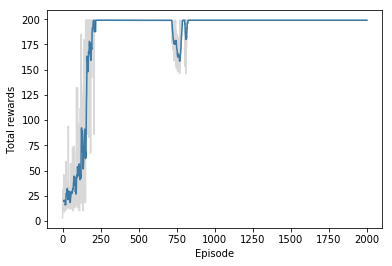

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

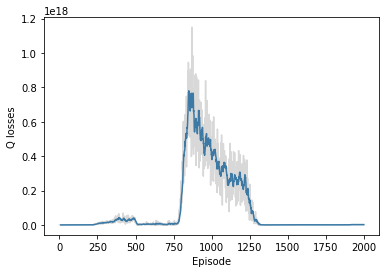

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

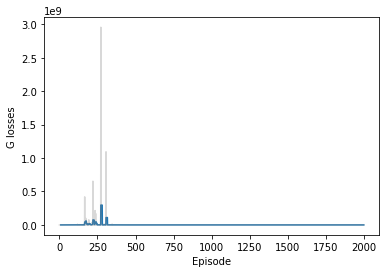

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

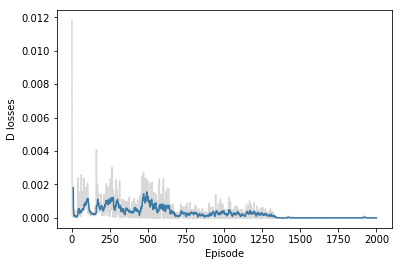

In [25]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.